In [1]:
from pathlib import Path
import os
import sys
import optuna
from optuna.samplers import TPESampler
from stable_baselines3 import DQN
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import ProgressBarCallback
import numpy as np
import torch
import random
import yaml
import pandas as pd
import matplotlib.pyplot as plt
path_to_src = Path(Path(os.getcwd()).parent, 'src')
sys.path.append(str(path_to_src))
from enviroment import StockTradingEnv
from agents import LinearFeatureExtractor, RNNFeatureExtractor, LSTMExtractor
from utils import get_data, get_scaled_data, get_time_data, prepare_aligned_data, daily_portfolio_return, statistics_calc
import warnings
warnings.filterwarnings('ignore')

# Импорт нужных функций для обучения

In [2]:
CONFIG = {
    "ticker": "NQ_1min",
    "model_type": "Linear",
    "window_size": 100,
    "price_column": 3,
    "num_actions": 3,
    "train_period": ("2019-07-23", "2023-01-11"),
    "val_period": ("2023-01-11", "2024-06-11"),
    "seed": 42,
    "default_params": {
        "learning_rate": 1e-4,
        "buffer_size": 100000,
        "learning_starts": 10000,
        "batch_size": 128,
        "gamma": 0.9,
        "exploration_fraction": 0.3,
        "exploration_initial_eps": 0.9,
        "exploration_final_eps": 0.05,
        "tensorboard_log": "logs/"
    },
    "optuna": {
        "n_trials": 0,
        "timeout": 3600,  # 1 час
        "direction": "maximize"
    }
}

In [3]:
# Фиксация сидов для воспроизводимости
def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


def create_env(data, scaled_data, time_data, config, mode='train'):
    """Создает окружение с синхронизированными данными"""
    train_start, train_end = config["train_period"]
    val_start, val_end = config["val_period"]
    
    # Создаем маску для выбранного периода
    if mode == 'train':
        mask = (data.index >= train_start) & (data.index <= train_end)
    else:
        mask = (data.index >= val_start) & (data.index <= val_end)
    
    # Применяем маску
    data_segment = data[mask] # исторические данные OLHC
    scaled_segment = scaled_data[mask] # признаковое описание (тех индикаторы и тд)
    time_segment = time_data[mask] # временные признаки
    
    # Проверка согласованности
    assert len(data_segment) == len(scaled_segment) == len(time_segment), \
        f"Размеры не совпадают: data={len(data_segment)}, scaled={len(scaled_segment)}, time={len(time_segment)}"
    
    env_kwargs = {
        "data": data_segment[['open', 'high', 'low', 'close']].values.astype(np.float32),
        "scaled_data": scaled_segment.values.astype(np.float32),
        "time_data": time_segment.values.astype(np.float32),
        "window_size": config["window_size"],
        "price_column": config["price_column"],
        "num_actions": config["num_actions"], 
        "timestamps": data_segment.index.values
    }
    
    return make_vec_env(
        lambda: StockTradingEnv(**env_kwargs),
        n_envs=1,
        vec_env_cls=DummyVecEnv
    )


# Конфигурация модели
def get_model_config(model_type, trial=None):
    """Возвращает конфигурацию для выбранного типа модели"""
    base_config = {
        "Linear": {
            "features_extractor_class": LinearFeatureExtractor,
            "features_extractor_kwargs": {
                "features_dim": trial.suggest_int("linear_dim", 16, 128) if trial else 32
            }
        },
        "RNN": {
            "features_extractor_class": RNNFeatureExtractor,
            "features_extractor_kwargs": {
                "features_dim": trial.suggest_int("rnn_dim", 32, 256) if trial else 64,
                "hidden_size": trial.suggest_int("rnn_hidden", 64, 512) if trial else 128
            }
        },
        "LSTM": {
            "features_extractor_class": LSTMExtractor,
            "features_extractor_kwargs": {
                "features_dim": trial.suggest_int("lstm_dim", 32, 256) if trial else 64,
                "hidden_size": trial.suggest_int("lstm_hidden", 64, 512) if trial else 128
            }
        }
    }
    
    return base_config.get(model_type, base_config["Linear"])  

In [4]:
def train_model(config, trial=None):
    """Обучает модель с заданной конфигурацией"""
    set_seeds(config["seed"])
    
    # Получаем синхронизированные данные
    data_array, scaled_array, time_array, full_index = prepare_aligned_data(
        config["ticker"], config
    )
    
    # Создаем окружения
    env_train = create_env(data_array, scaled_array, time_array, config, 'train')
    env_val = create_env(data_array, scaled_array, time_array, config, 'val')

    params = config["default_params"].copy()

    tb_log = params.pop("tensorboard_log")
    tb_log_path = f"save/{tb_log}/{config['model_type']}_{trial.number if trial else 'default'}"

    if trial:
        params.update({
            "learning_rate": trial.suggest_float("lr", 1e-5, 1e-2, log=True),
            "batch_size": trial.suggest_categorical("batch_size", [32, 64, 128, 256]),
            "gamma": trial.suggest_float("gamma", 0.9, 0.999),
            "exploration_fraction": trial.suggest_float("exploration_frac", 0.1, 0.5),
            "buffer_size": trial.suggest_int("buffer_size", 5000, 100000)
        })
    
    model_config = get_model_config(config["model_type"], trial=trial)

    model = DQN(
        "MlpPolicy",
        env_train,
        policy_kwargs=model_config,
        verbose=1,
        tensorboard_log=tb_log_path,
        #replay_buffer_kwargs=dict(optimize_memory_usage=True),
        device="auto",
        **params
    )

    print(model_config)
    model.learn(
        total_timesteps=1000000,
        callback=ProgressBarCallback(),
        log_interval=100,
        tb_log_name=f"{config['model_type']}_{trial.number if trial else 'default'}"
    )
    print('Обучение завершено')
    #sharpe_ratio, returns, b_h_ret = evaluate_daily_sharpe(model, env_val)
    returns, b_h_ret = daily_portfolio_return(env_val, model)
    if not trial:
        save_path = Path("models", f"{config['ticker']}_{config['model_type']}")
        model.save(str(save_path))
    
    metrics = statistics_calc(returns, b_h_ret, plot=True)
    return metrics, returns, b_h_ret, model

def objective(trial):
    """Целевая функция для оптимизации гиперпараметров"""
    config = CONFIG.copy()
    # config["model_type"] = trial.suggest_categorical("model_type", ["Linear", "RNN", "LSTM"])
    return train_model(config, trial)

In [5]:
def objective(trial):
    """Целевая функция для оптимизации гиперпараметров"""
    config = CONFIG.copy()
    # config["model_type"] = trial.suggest_categorical("model_type", ["Linear", "RNN", "LSTM"])
    return train_model(config, trial)


In [6]:
set_seeds(CONFIG["seed"])

# Формирование датасета случайного блуждания

In [7]:
PATH_TO_DATA = Path(os.getcwd()).parent / "data"

In [8]:
data_nq = pd.read_csv(str(PATH_TO_DATA / "NQ_1min.csv"), sep=',', index_col='timestamp', parse_dates=True)
data_nq[~data_nq.index.duplicated(keep='first')]
data_nq

,open,high,low,close,volume,price_diff,ret,log_ret,ticker
timestamp,,,,,,,,,
2019-07-23 00:06:00,7953.00,7953.00,7953.00,7953.00,1.0,NaN,NaN,NaN,NQZ9
2019-07-23 00:09:00,7952.00,7952.00,7952.00,7952.00,1.0,-1.00,-0.000126,-0.000126,NQZ9
2019-07-23 00:17:00,7947.75,7947.75,7947.75,7947.75,1.0,-4.25,-0.000534,-0.000535,NQZ9
2019-07-23 00:24:00,7941.75,7941.75,7941.75,7941.75,1.0,-6.00,-0.000755,-0.000755,NQZ9
2019-07-23 00:43:00,7939.25,7939.25,7939.25,7939.25,1.0,-2.50,-0.000315,-0.000315,NQZ9
...,...,...,...,...,...,...,...,...,...
2024-06-11 08:11:00,19097.00,19100.75,19096.75,19099.50,61.0,3.75,0.000196,0.000196,NQM4
2024-06-11 08:12:00,19099.25,19099.25,19093.75,19096.50,97.0,-3.00,-0.000157,-0.000157,NQM4
2024-06-11 08:13:00,19096.25,19099.50,19095.75,19098.25,45.0,1.75,0.000092,0.000092,NQM4


# Simple random walk

In [53]:
data_random_walk = pd.DataFrame(
    index=data_nq.index,
    columns=['open', 'high', 'low', 'close'],
    dtype=float
)

In [57]:
start_price = 1000
mu = 0          
sigma = 1       
vol_multiplier = 0.5  # Множитель для диапазона high/low

data_random_walk.iloc[0, 3] = start_price  # close
data_random_walk.iloc[0, 0] = start_price  # open

# Генерация приращений для всех дней
increments = np.random.normal(mu, sigma, len(data_nq))

for i in range(len(data_random_walk)):
    if i > 0:
        # OPEN = предыдущий CLOSE
        data_random_walk.iloc[i, 0] = data_random_walk.iloc[i-1, 3]  
        
        # CLOSE = OPEN + случайное приращение
        data_random_walk.iloc[i, 3] = data_random_walk.iloc[i, 0] + increments[i]
    
    # Расчет внутридневного диапазона
    daily_range = abs(increments[i]) * vol_multiplier
    
    # HIGH и LOW с учетом внутридневной волатильности
    data_random_walk.iloc[i, 1] = max(data_random_walk.iloc[i, 0], data_random_walk.iloc[i, 3]) + np.random.uniform(0, daily_range)
    data_random_walk.iloc[i, 2] = min(data_random_walk.iloc[i, 0], data_random_walk.iloc[i, 3]) - np.random.uniform(0, daily_range)

data_random_walk['log_ret'] = np.log(data_random_walk['close'] / data_random_walk['close'].shift(1))

data_random_walk = data_random_walk[~(data_random_walk.index == 0)]

In [58]:
data_random_walk

,open,high,low,close,log_ret
timestamp,,,,,
2019-07-23 00:06:00,1000.000000,1000.010229,999.999264,1000.000000,NaN
2019-07-23 00:09:00,1000.000000,1001.194657,999.750446,1001.113826,0.001113
2019-07-23 00:17:00,1001.113826,1001.181893,1000.910231,1000.959144,-0.000155
2019-07-23 00:24:00,1000.959144,1001.213237,1000.273658,1000.418852,-0.000540
2019-07-23 00:43:00,1000.418852,1000.484863,1000.015920,1000.147447,-0.000271
...,...,...,...,...,...
2024-06-11 08:11:00,233.505888,233.978360,231.744428,231.927615,-0.006782
2024-06-11 08:12:00,231.927615,232.381302,231.863296,232.305437,0.001628
2024-06-11 08:13:00,232.305437,232.699758,231.159780,231.429433,-0.003778


In [59]:
data_random_walk.to_csv(str(PATH_TO_DATA / 'random_walk.csv'), encoding='utf-8-sig', index=True)

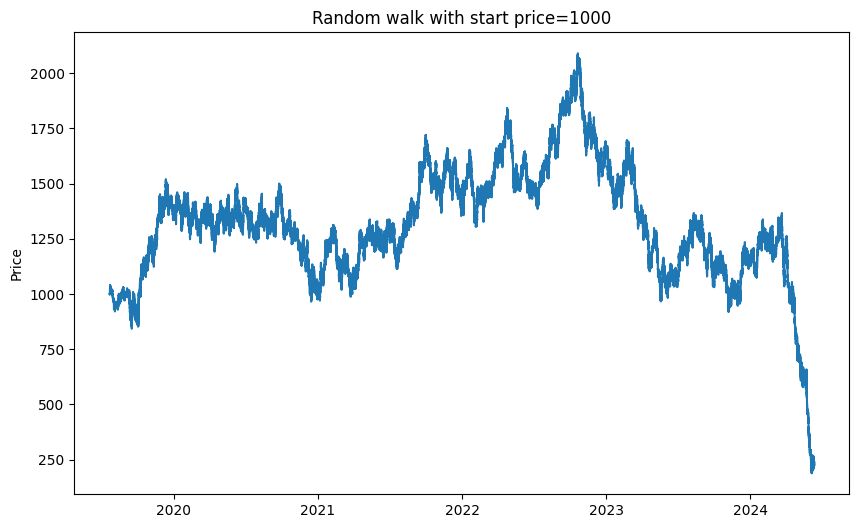

In [60]:
plt.figure(figsize=(10, 6))
plt.plot(data_random_walk.index, data_random_walk['close'])
plt.title(f"Random walk with start price={start_price}")
plt.ylabel("Price")
plt.show()

Using cpu device
{'features_extractor_class': <class 'agents.LinearFeatureExtractor'>, 'features_extractor_kwargs': {'features_dim': 32}}
Logging to save/logs//Linear_default\Linear_default_29


Output()

Обучение завершено


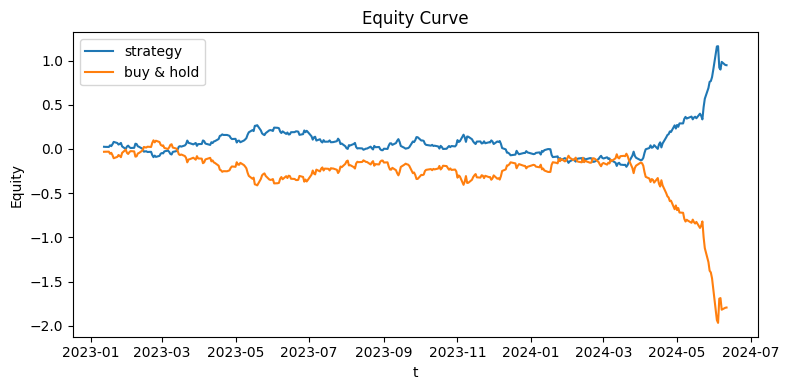

In [61]:
CONFIG['ticker'] = 'random_walk'
if CONFIG["optuna"]["n_trials"] > 0:
    # Оптимизация гиперпараметров с Optuna
    study = optuna.create_study(
        direction=CONFIG["optuna"]["direction"],
        sampler=TPESampler(seed=CONFIG["seed"])
    )

    study.optimize(
        objective,
        n_trials=CONFIG["optuna"]["n_trials"],
        timeout=CONFIG["optuna"]["timeout"],
        show_progress_bar=True
    )

    best_params = study.best_params
    
    with open("best_params.yaml", "w") as f:
        yaml.dump(best_params, f)
        
    print(f"Лучшие параметры: {best_params}")
    print(f"Лучшая награда: {study.best_value}")

    # Обучение финальной модели с лучшими параметрами
    # CONFIG["model_type"] = best_params["model_type"]
    CONFIG["default_params"].update({
        k: v for k, v in best_params.items() 
        if k not in ["model_type", "linear_dim", "rnn_dim", "rnn_hidden", "lstm_dim", "lstm_hidden"]
    })
    metrics, ret_cur, b_h_ret_cur, model = train_model(CONFIG)
else:
    # Простое обучение без оптимизации
    metrics, ret_cur, b_h_ret_cur, model = train_model(CONFIG)

In [63]:
metrics

,Sharpe ratio,Annual return,Volatility
_,1.486492,0.946324,0.636615


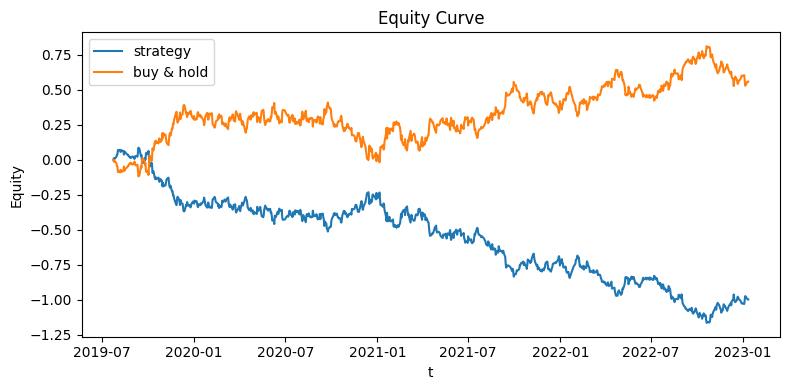

In [64]:
data_array, scaled_array, time_array, full_index = prepare_aligned_data(
    CONFIG["ticker"], CONFIG
)

env_train = create_env(data_array, scaled_array, time_array, CONFIG, 'train')

ret, b_h = daily_portfolio_return(env_train, model)

metrics = statistics_calc(ret, b_h, plot=True)

In [65]:
metrics

,Sharpe ratio,Annual return,Volatility
_,-1.072813,-0.406192,0.378623


In [16]:
CONFIG = {
    "ticker": "random_walk",
    "model_type": "Linear",
    "window_size": 100,
    "price_column": 3,
    "num_actions": 3,
    "train_period": ("2019-07-23", "2019-08-11"),
    "val_period": ("2019-08-11", "2019-08-25"),
    "seed": 42,
    "default_params": {
        "learning_rate": 1e-4,
        "buffer_size": 100000,
        "learning_starts": 10000,
        "batch_size": 128,
        "gamma": 0.9,
        "exploration_fraction": 0.3,
        "exploration_initial_eps": 0.9,
        "exploration_final_eps": 0.05,
        "tensorboard_log": "logs/"
    },
    "optuna": {
        "n_trials": 0,
        "timeout": 3600,  # 1 час
        "direction": "maximize"
    }
}

Using cpu device
{'features_extractor_class': <class 'agents.LinearFeatureExtractor'>, 'features_extractor_kwargs': {'features_dim': 32}}
Logging to save/logs//Linear_default\Linear_default_30


Output()

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.6e+03  |
|    ep_rew_mean      | 941      |
|    exploration_rate | 0.162    |
| time/               |          |
|    episodes         | 100      |
|    fps              | 1044     |
|    time_elapsed     | 249      |
|    total_timesteps  | 260400   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.29     |
|    n_updates        | 62599    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.6e+03  |
|    ep_rew_mean      | 3.18e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 200      |
|    fps              | 1013     |
|    time_elapsed     | 513      |
|    total_timesteps  | 520800   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.73     |
|    n_updates      

Обучение завершено


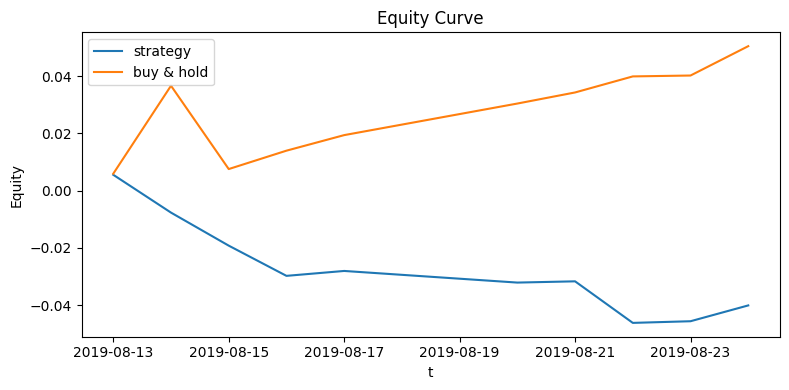

In [68]:
if CONFIG["optuna"]["n_trials"] > 0:
    # Оптимизация гиперпараметров с Optuna
    study = optuna.create_study(
        direction=CONFIG["optuna"]["direction"],
        sampler=TPESampler(seed=CONFIG["seed"])
    )

    study.optimize(
        objective,
        n_trials=CONFIG["optuna"]["n_trials"],
        timeout=CONFIG["optuna"]["timeout"],
        show_progress_bar=True
    )

    best_params = study.best_params
    
    with open("best_params.yaml", "w") as f:
        yaml.dump(best_params, f)
        
    print(f"Лучшие параметры: {best_params}")
    print(f"Лучшая награда: {study.best_value}")

    # Обучение финальной модели с лучшими параметрами
    # CONFIG["model_type"] = best_params["model_type"]
    CONFIG["default_params"].update({
        k: v for k, v in best_params.items() 
        if k not in ["model_type", "linear_dim", "rnn_dim", "rnn_hidden", "lstm_dim", "lstm_hidden"]
    })
    metrics, ret_cur, b_h_ret_cur, model = train_model(CONFIG)
else:
    # Простое обучение без оптимизации
    metrics, ret_cur, b_h_ret_cur, model = train_model(CONFIG)

In [69]:
metrics

,Sharpe ratio,Annual return,Volatility
_,-10.345088,-1.465206,0.141633


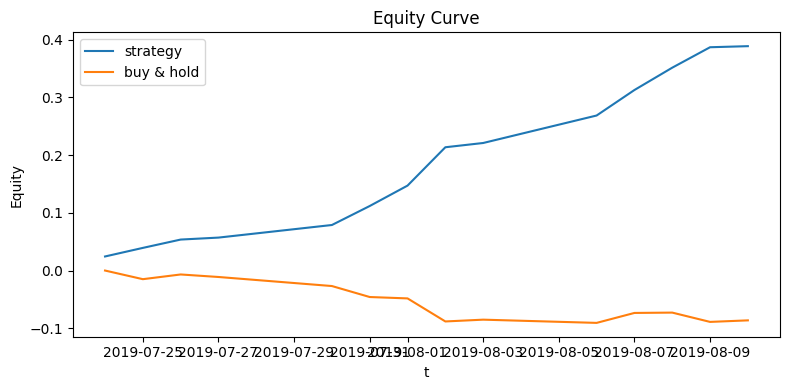

In [70]:
data_array, scaled_array, time_array, full_index = prepare_aligned_data(
    CONFIG["ticker"], CONFIG
)

env_train = create_env(data_array, scaled_array, time_array, CONFIG, 'train')

ret, b_h = daily_portfolio_return(env_train, model)

metrics = statistics_calc(ret, b_h, plot=True)

In [71]:
metrics

,Sharpe ratio,Annual return,Volatility
_,29.654717,10.139128,0.341906


Получили те же результаты, что и при тестировании на реальной временном ряде. На маленьких окнах модель выучивает зависимости (на месячном окне 29 шарп, на валидации плохо, что очевидно, ведь у нас независимые приращения на каждом шаге), но чем больше окно, тем модель хуже начинает обучаться. Она как будто учиться предсказывать инверсию позиции и это не зависит от вида временного ряда. То есть скорее всего, если понять почему так происходит, то проблема решится глобально для всех видов временных рядов.

Теперь протестируем модель на автогрегрессионных моделях, где есть коррелирующие случайные величины. Мы должны увидеть, что модель на обучении сможет выдавать хорошие результаты и на валидации тоже.

# AR, MA, ARIMA модели

In [9]:
from statsmodels.tsa.arima_process import ArmaProcess

def generate_correlated_series(index, model_type='ar', params=(0.9,), start_price=1000, vol_multiplier=0.5):
    """
    Генерирует OHLC данные с автокорреляцией
    
    Параметры:
    index : pd.Index
        Временные метки (из data_nq.index)
    model_type : str
        'ar', 'ma' или 'arima'
    params : tuple
        Параметры модели:
        - AR: (phi1, phi2, ...)
        - MA: (theta1, theta2, ...)
        - ARIMA: (ar_params, ma_params) 
          Пример: ([0.8, -0.2], [0.3, 0.1])
    start_price : float
        Начальная цена
    vol_multiplier : float
        Множитель внутридневной волатильности
    """
    n = len(index)
    data = pd.DataFrame(
        index=index,
        columns=['open', 'high', 'low', 'close'],
        dtype=float
    )
    
    # Генерация процесса с автокорреляцией
    if model_type == 'ar':
        # AR(p) процесс
        p = len(params)
        ar = np.r_[1, -np.array(params)]
        ma = np.array([1])
        log_returns = np.zeros(n)
        
        for t in range(p, n):
            ar_component = np.dot(ar[1:], log_returns[t-p:t][::-1])
            log_returns[t] = ar_component + np.random.normal(0, 1)
    
    elif model_type == 'ma':
        # MA(q) процесс
        q = len(params)
        ma = np.r_[1, params]
        ar = np.array([1])
        log_returns = np.zeros(n)
        errors = np.random.normal(0, 1, n + q)
        
        for t in range(q, n):
            ma_component = np.dot(ma[1:], errors[t-q:t][::-1])
            log_returns[t] = errors[t] + ma_component
    
    elif model_type == 'arima':
        # ARIMA(p,d,q) процесс
        ar_params, ma_params = params
        p, q = len(ar_params), len(ma_params)
        ar = np.r_[1, -np.array(ar_params)]
        ma = np.r_[1, ma_params]
        process = ArmaProcess(ar, ma)
        log_returns = process.generate_sample(n + 100)[100:]  # Обрезаем burn-in
    
    # Нормализация волатильности
    log_returns = log_returns / np.std(log_returns) * 0.01  # 1% дневная волатильность
    
    # Построение цен закрытия
    close_prices = start_price * np.exp(np.cumsum(log_returns))
    
    # Заполнение OHLC
    data['close'] = close_prices
    data['open'] = data['close'].shift(1)
    data.loc[data.index[0], 'open'] = start_price
    
    # Расчет внутридневных колебаний
    for i in range(len(data)):
        daily_range = abs(log_returns[i]) * vol_multiplier * start_price
        data.loc[data.index[i], 'high'] = max(data.iloc[i]['open'], data.iloc[i]['close']) + np.random.uniform(0, daily_range)
        data.loc[data.index[i], 'low'] = min(data.iloc[i]['open'], data.iloc[i]['close']) - np.random.uniform(0, daily_range)
    
    data['log_ret'] = np.log(data['close'] / data['close'].shift(1))
    return data.dropna()

In [ ]:
data_ar = generate_correlated_series(
    index=data_nq.index,
    model_type='ar',
    params=(0.9,),  
    start_price=1000
)

In [12]:
data_ar

,open,high,low,close,log_ret
timestamp,,,,,
2019-07-23 00:09:00,1000.000000,1003.159375,999.444292,1002.162233,0.002160
2019-07-23 00:17:00,1002.162233,1003.031269,999.315154,999.614839,-0.002545
2019-07-23 00:24:00,999.614839,1004.903484,998.493432,1004.732942,0.005107
2019-07-23 00:43:00,1004.732942,1007.543087,1003.998372,1006.770989,0.002026
2019-07-23 00:44:00,1006.770989,1007.254339,1003.058327,1003.913869,-0.002842
...,...,...,...,...,...
2024-06-11 08:11:00,10.455362,11.533469,8.595389,10.409811,-0.004366
2024-06-11 08:12:00,10.409811,11.154986,10.260552,10.426730,0.001624
2024-06-11 08:13:00,10.426730,12.098718,8.187798,10.475408,0.004658


In [15]:
data_ar.to_csv(str(PATH_TO_DATA / 'ar(1).csv'))

Запуск на маленьком окне данных

Using cpu device
{'features_extractor_class': <class 'agents.LinearFeatureExtractor'>, 'features_extractor_kwargs': {'features_dim': 32}}
Logging to save/logs//Linear_default\Linear_default_33


Output()

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.6e+03  |
|    ep_rew_mean      | 1.42e+04 |
|    exploration_rate | 0.162    |
| time/               |          |
|    episodes         | 100      |
|    fps              | 1060     |
|    time_elapsed     | 245      |
|    total_timesteps  | 260300   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 39.5     |
|    n_updates        | 62574    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.6e+03  |
|    ep_rew_mean      | 2.68e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 200      |
|    fps              | 993      |
|    time_elapsed     | 524      |
|    total_timesteps  | 520600   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 33.4     |
|    n_updates      

Обучение завершено


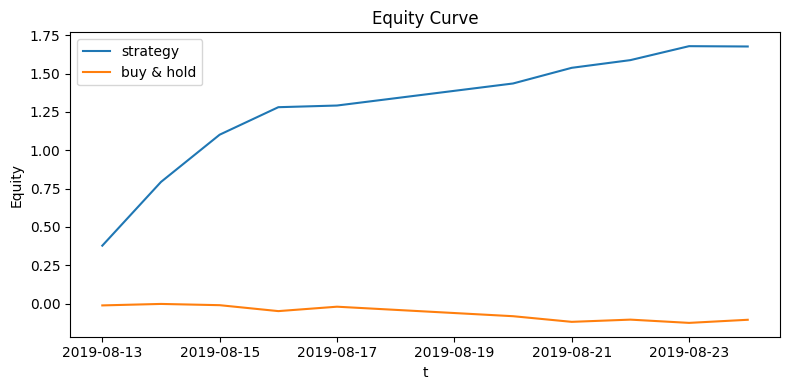

In [20]:
CONFIG['ticker'] = 'ar(1)'
if CONFIG["optuna"]["n_trials"] > 0:
    # Оптимизация гиперпараметров с Optuna
    study = optuna.create_study(
        direction=CONFIG["optuna"]["direction"],
        sampler=TPESampler(seed=CONFIG["seed"])
    )

    study.optimize(
        objective,
        n_trials=CONFIG["optuna"]["n_trials"],
        timeout=CONFIG["optuna"]["timeout"],
        show_progress_bar=True
    )

    best_params = study.best_params
    
    with open("best_params.yaml", "w") as f:
        yaml.dump(best_params, f)
        
    print(f"Лучшие параметры: {best_params}")
    print(f"Лучшая награда: {study.best_value}")

    # Обучение финальной модели с лучшими параметрами
    # CONFIG["model_type"] = best_params["model_type"]
    CONFIG["default_params"].update({
        k: v for k, v in best_params.items() 
        if k not in ["model_type", "linear_dim", "rnn_dim", "rnn_hidden", "lstm_dim", "lstm_hidden"]
    })
    metrics, ret_cur, b_h_ret_cur, model = train_model(CONFIG)
else:
    # Простое обучение без оптимизации
    metrics, ret_cur, b_h_ret_cur, model = train_model(CONFIG)

In [21]:
metrics

,Sharpe ratio,Annual return,Volatility
_,22.467299,61.246941,2.726048


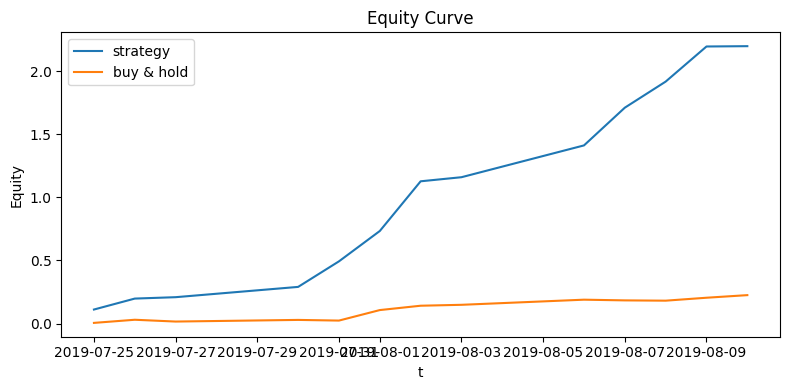

In [22]:
data_array, scaled_array, time_array, full_index = prepare_aligned_data(
    CONFIG["ticker"], CONFIG
)

env_train = create_env(data_array, scaled_array, time_array, CONFIG, 'train')

ret, b_h = daily_portfolio_return(env_train, model)

metrics = statistics_calc(ret, b_h, plot=True)

In [23]:
metrics

,Sharpe ratio,Annual return,Volatility
_,27.241006,61.745606,2.266642


Как и ожидалось: и на трейне хорошее качество, что и на валидации.

In [11]:
data_ar = generate_correlated_series(
    index=data_nq.index,
    model_type='arima',
    params=([0.8, -0.2], [0.3, 0.1]),  
    start_price=1000
)

In [13]:
data_ar

,open,high,low,close,log_ret
timestamp,,,,,
2019-07-23 00:09:00,9.908543e+02,993.879219,975.692518,9.788857e+02,-0.012153
2019-07-23 00:17:00,9.788857e+02,979.696976,966.809110,9.677875e+02,-0.011402
2019-07-23 00:24:00,9.677875e+02,970.406580,953.128949,9.561005e+02,-0.012150
2019-07-23 00:43:00,9.561005e+02,960.562216,945.427009,9.466315e+02,-0.009953
2019-07-23 00:44:00,9.466315e+02,947.528060,942.225119,9.429041e+02,-0.003945
...,...,...,...,...,...
2024-06-11 08:11:00,4.106235e-15,4.959350,-7.528056,4.020349e-15,-0.021138
2024-06-11 08:12:00,4.020349e-15,3.063059,-0.302201,3.986305e-15,-0.008504
2024-06-11 08:13:00,3.986305e-15,2.663234,-2.702726,4.008383e-15,0.005523


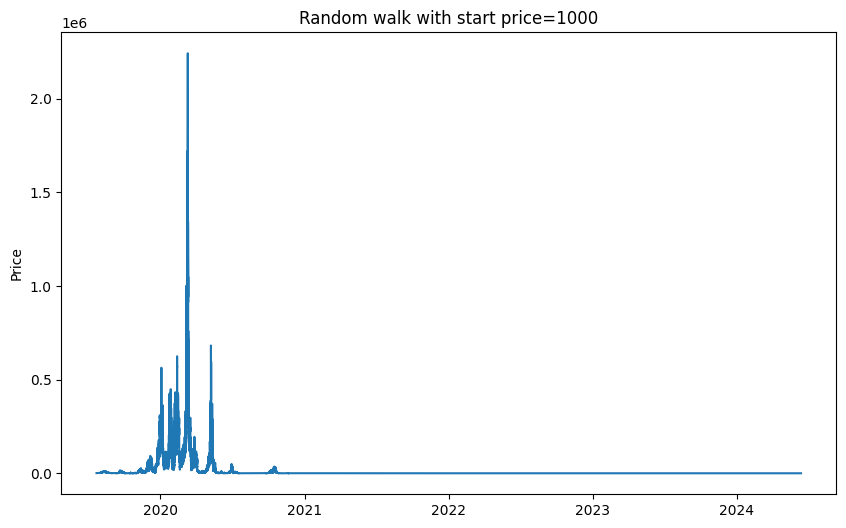

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(data_ar.index, data_ar['close'])
plt.title(f"Random walk with start price={start_price}")
plt.ylabel("Price")
plt.show()

In [17]:
data_ar.to_csv(PATH_TO_DATA / "arima(1,1,1).csv", encoding='utf-8-sig', index=True)